In [1]:
import numpy as np
import random
from functools import reduce
import matplotlib.pyplot as plt
n_qubits = 10
n_layers=1
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Rotation gate around Y-axis
def RY(theta):
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2),  np.cos(theta/2)]
    ])

#Tensor product 
def kron_n(*ops):
    return reduce(np.kron, ops)
#initial state |000...0⟩
def initial_state(n):
    state = np.zeros(2**n, dtype=complex)
    state[0] = 1.0
    return state
#Construct full CNOT
def get_cnot_matrix(n_qubits, control, target):
    P0 = np.array([[1, 0], [0, 0]])  # |0⟩⟨0|
    P1 = np.array([[0, 0], [0, 1]])  # |1⟩⟨1|
    
    ops_0 = []
    ops_1 = []
    
    for i in range(n_qubits):
        if i == control:
            ops_0.append(P0)
            ops_1.append(P1)
        elif i == target:
            ops_0.append(I)
            ops_1.append(X)
        else:
            ops_0.append(I)
            ops_1.append(I)
    
    term1 = kron_n(*ops_0)
    term2 = kron_n(*ops_1)
    return term1 + term2
#Apply single-qubit gate
def apply_single_qubit_gate(state, gate, target, n_qubits):
    ops = [I] * n_qubits
    ops[target] = gate
    U = kron_n(*ops)
    return U @ state
#Applying CNOT
def apply_cnot(state, control, target, n_qubits):
    U_cnot = get_cnot_matrix(n_qubits, control, target)
    return U_cnot @ state
def hamiltonian(n_qubits, edges, seed):
    np.random.seed(seed)
    weights = np.random.uniform(0.2, 0.8, len(edges))
    
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)

    for (idx, (i, j)) in enumerate(edges):
        ops = [I] * n_qubits
        ops[i] = Z
        ops[j] = Z
        term = weights[idx] * kron_n(*ops)
        H += term

    return H, weights
def print_symbolic_hamiltonian(edges, weights):
    print("H = ", end="")
    terms = []
    for (i, j), w in zip(edges, weights):
        terms.append(f"{w:.3f} * Z[{i}]Z[{j}]")
    print(" + ".join(terms))
def ansatz(theta, n_qubits, edges, n_layers):
    state = initial_state(n_qubits)
    param_idx = 0

    for _ in range(n_layers):
        # Apply RY rotation to each qubit
        for i in range(n_qubits):
            angle = theta[param_idx]
            param_idx += 1
            ry_gate = RY(angle)
            state = apply_single_qubit_gate(state, ry_gate, i, n_qubits)

        # Apply CNOTs based on Hamiltonian structure
        for control, target in edges:
            state = apply_cnot(state, control, target, n_qubits)
    state = state / np.linalg.norm(state)
    return state

def generate_random_edges(n_qubits, n_edges, seed):
    random.seed(seed)
    all_possible_edges = [(i, j) for i in range(n_qubits) for j in range(i + 1, n_qubits)]
    edges = random.sample(all_possible_edges, min(n_edges, len(all_possible_edges)))
    return edges




In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_qubit_connectivity(n_qubits, edges,seed):
    G = nx.Graph()
    G.add_nodes_from(range(n_qubits))
    G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed)  # Force-directed layout
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color='gray', width=2)
    plt.title("Qubit Connectivity Graph (Based on Hamiltonian Edges)")
    plt.show()



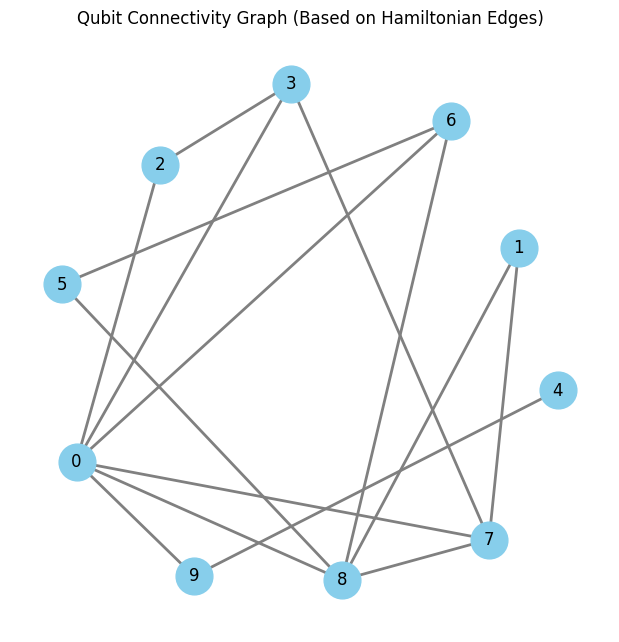

In [3]:
n_qubits = 10
n_edges = 15
seed = 42   
n_layers = 4
pdim=n_layers*n_qubits
edges = generate_random_edges(n_qubits, n_edges, seed)
visualize_qubit_connectivity(n_qubits, edges,seed)


In [4]:
def expectation(theta, H, n_qubits, n_layers):
    psi = ansatz(theta, n_qubits,edges, n_layers)
    return np.real(np.vdot(psi, H @ psi))
H, weights = hamiltonian(n_qubits, edges, seed)
print_symbolic_hamiltonian(edges, weights)
def cost(theta):
    return expectation(theta, H, n_qubits,n_layers)


H = 0.425 * Z[6]Z[8] + 0.770 * Z[0]Z[8] + 0.639 * Z[0]Z[2] + 0.559 * Z[2]Z[3] + 0.294 * Z[1]Z[8] + 0.294 * Z[1]Z[7] + 0.235 * Z[0]Z[9] + 0.720 * Z[0]Z[7] + 0.561 * Z[4]Z[9] + 0.625 * Z[0]Z[6] + 0.212 * Z[3]Z[7] + 0.782 * Z[0]Z[3] + 0.699 * Z[7]Z[8] + 0.327 * Z[5]Z[6] + 0.309 * Z[5]Z[8]


In [5]:
def ansatz(theta, n_qubits, edges, n_layers, return_all_states=False):
    state = initial_state(n_qubits)
    param_idx = 0
    state_history = []  # to store state after each layer

    for layer in range(n_layers):
        # Apply RY rotations
        for i in range(n_qubits):
            angle = theta[param_idx]
            param_idx += 1
            ry_gate = RY(angle)
            state = apply_single_qubit_gate(state, ry_gate, i, n_qubits)

        # Apply CNOTs based on edges
        for control, target in edges:
            state = apply_cnot(state, control, target, n_qubits)

        # Normalize and store copy of current state
        state = state / np.linalg.norm(state)
        if return_all_states:
            state_history.append(state.copy())

    if return_all_states:
        return state_history
    else:
        return state


In [6]:
theta = np.random.uniform(0, 2*np.pi, n_layers * n_qubits)

# Get all intermediate states
states = ansatz(theta, n_qubits, edges, n_layers, return_all_states=True)

# Print overlaps with final state
final_state = states[-1]
for i, psi in enumerate(states[:-1]):
    overlap = np.abs(np.vdot(psi, final_state))**2
    print(f"Overlap of layer {i+1} state with final state: {overlap:.6f}")


Overlap of layer 1 state with final state: 0.000497
Overlap of layer 2 state with final state: 0.000065
Overlap of layer 3 state with final state: 0.000218


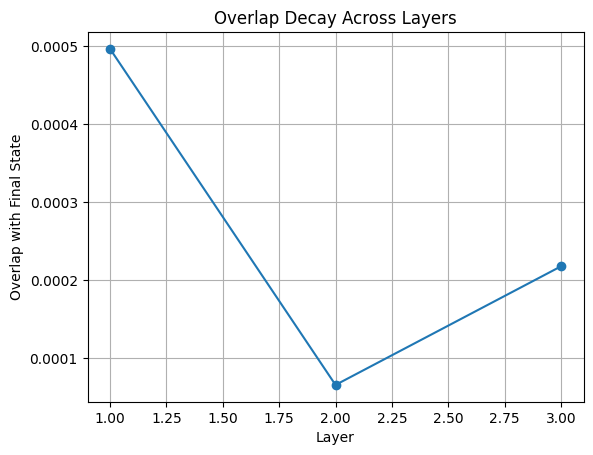

In [7]:
import matplotlib.pyplot as plt

overlaps = [np.abs(np.vdot(psi, final_state))**2 for psi in states[:-1]]

plt.plot(range(1, n_layers), overlaps, marker='o')
plt.xlabel("Layer")
plt.ylabel("Overlap with Final State")
plt.title("Overlap Decay Across Layers")
plt.grid(True)
plt.show()


In [8]:
# Use optimized thetas
theta_opt = [-8.84148177e-08,  3.13325373e+00 , 3.80106343e+00,  4.71240737e+00,
  6.06984548e+00 , 2.98119356e+00 , 5.50228549e+00 , 5.75156742e+00,
  1.57079660e+00 , 1.18597559e+00 , 3.14159253e+00 , 3.10837784e+00,
  3.80106266e+00,  4.63799132e+00 , 4.89270785e+00 , 2.40440959e+00,
  4.18318524e-01,  4.84589562e+00 , 3.14159304e+00 , 6.10649662e+00,
 -6.97801068e-09 , 6.24509393e+00 , 1.18487774e-05 , 1.28458091e+00,
  7.59222748e-01 , 6.04226484e+00 , 5.80628482e+00 , 2.26539886e+00,
  6.28318490e+00 , 3.52010679e+00 , 3.14159265e+00 , 6.33246668e+00,
  3.14159279e+00 , 2.82563552e+00 , 5.32137923e+00  ,5.84489559e+00,
  5.47955713e+00  ,4.06171642e+00 ,-1.57079571e+00 , 5.40994954e+00]
states = ansatz(theta_opt, n_qubits, edges, n_layers, return_all_states=True)

# Final state
final_state = states[-1]

# Compute overlaps
for i, psi in enumerate(states[:-1]):
    overlap = np.abs(np.vdot(psi, final_state))**2
    print(f"Overlap of layer {i+1} state with final state: {overlap:.6f}")


Overlap of layer 1 state with final state: 0.000000
Overlap of layer 2 state with final state: 0.000000
Overlap of layer 3 state with final state: 0.000000


In [9]:
def layerwise_overlaps(theta_opt, n_qubits, edges, n_layers):
    """
    Reconstruct intermediate states and return overlaps with the final state.

    Parameters:
        theta_opt (ndarray): Optimized parameter vector (length = n_layers * n_qubits)
        n_qubits (int): Number of qubits
        edges (list): List of CNOT connections
        n_layers (int): Number of layers in the ansatz

    Returns:
        overlaps: list of overlaps |⟨ψ_k | ψ_final⟩|² for k = 1 to n_layers - 1
    """
    state = initial_state(n_qubits)
    param_idx = 0
    states = []
    k=0
    for layer in range(n_layers):
        # Apply Ry rotations
        for i in range(n_qubits):
            angle = theta_opt[param_idx]
            param_idx += 1
            ry_gate = RY(angle)
            state = apply_single_qubit_gate(state, ry_gate, i, n_qubits)

        # Apply CNOTs
        for control, target in edges:
            state = apply_cnot(state, control, target, n_qubits)

        # Normalize and store
        state = state / np.linalg.norm(state)
        states.append(state.copy())
        k+=1
        print(f"State after layer {k}: {state}")
    print(f"Final state after {n_layers} layers: {state}")
    final_state = states[-1]
    overlaps = [np.abs(np.vdot(psi, final_state))**2 for psi in states[:-1]]
    return overlaps


In [11]:
theta_opt = [ 3.15245441e+00 , 6.19066414e+00  ,3.13004495e+00,  2.64987448e+00,
  1.29994036e+00 , 2.76974589e+00 , 1.39524736e+00 , 4.71097286e+00,
  4.71426139e+00 ,-1.79204626e+00 , 6.28612376e+00 , 3.13851393e+00,
  2.99011925e+00 , 2.05913834e+00  ,4.03170523e+00 , 4.62520999e+00,
  3.10426998e+00 , 3.13952274e+00 , 1.38292441e-03 , 3.15237866e+00,
 -8.91592221e-03 , 1.33238901e+00 , 6.13000668e+00 , 4.81751938e+00,
  1.01373714e-01 , 1.98539185e+00 , 5.02213279e+00 , 6.28450324e+00,
  6.28241967e+00,  5.66457687e+00 , 3.14272589e+00 , 4.37881261e+00,
  1.04446441e-02,  3.04110870e+00 , 3.50264678e+00  ,2.99452563e+00,
  6.58700839e+00,  4.71240202e+00 , 1.56888581e+00  ,2.06435941e+00]
overlaps = layerwise_overlaps(theta_opt, n_qubits=10, edges=edges, n_layers=4)

for i, ov in enumerate(overlaps):
    print(f"Overlap of layer {i+1} state with final state: {ov:.6f}")


State after layer 1: [ 2.68632868e-07+0.j -3.35768883e-07+0.j -2.68130348e-07+0.j ...
 -3.86203876e-05+0.j -3.09562617e-05+0.j  3.86927686e-05+0.j]
State after layer 2: [ 4.48449835e-06+0.j  1.26400711e-05+0.j -4.48591070e-06+0.j ...
 -8.29579292e-03+0.j  7.41990713e-03+0.j  8.32326276e-03+0.j]
State after layer 3: [-3.97746527e-07+0.j -7.30276659e-07+0.j  3.33924353e-07+0.j ...
  2.02386960e-01+0.j -3.39011035e-01+0.j -2.02198702e-01+0.j]
State after layer 4: [-2.06920701e-10+0.j  1.28217229e-09+0.j  1.47757759e-10+0.j ...
  1.07878703e-12+0.j  1.36820903e-12+0.j  2.28348074e-13+0.j]
Final state after 4 layers: [-2.06920701e-10+0.j  1.28217229e-09+0.j  1.47757759e-10+0.j ...
  1.07878703e-12+0.j  1.36820903e-12+0.j  2.28348074e-13+0.j]
Overlap of layer 1 state with final state: 0.000000
Overlap of layer 2 state with final state: 0.000000
Overlap of layer 3 state with final state: 0.000000
